# Ejemplo IRKGL16

# Definiciones

In [2]:
import Pkg; Pkg.add("ForwardDiff")
import Pkg; Pkg.add("Optim")
import Pkg; Pkg.add("IRKGaussLegendre")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
   Installed SIMD ───────────── v3.7.1
   Installed IRKGaussLegendre ─ v0.2.10
    Updating `~/.julia/environments/v1.11/Project.toml`
  [58bc7355] + IRKGaussLegendre v0.2.10
    Updating `~/.julia/environments/v1.11/Manifest.toml`
  [58bc7355] + IRKGaussLegendre v0.2.10
  [fdea26ae] + SIMD v3.7.1
Precompiling project...
   5339.1 ms  ✓ SIMD
   1339.7 ms  ✓ IRKGaussLegendre
  2 dependencies successfully precompiled in 7 seconds. 407 already precompiled.


In [3]:
using Plots
using LinearAlgebra
using OrdinaryDiffEq
using IRKGaussLegendre

**Repositorio IRKGaussLegendre:**
- https://github.com/SciML/IRKGaussLegendre.jl

## Problema del satélite artificial

Consideraremos la evolución de un satélite artificial moviéndose bajo el influjo gravitacional de la tierra. 

 En el modelo matemático que consideramos a continuación, se tiene en cuenta el ligero achatamiento que presenta la tierra en los polos. (Sin embargo, no se tiene en cuenta otros efectos de índole menor, como  el efecto gravitacional de la luna, el sol, y otros cuerpos celestes, ni el efecto de irregularidades menores del campo gravitacional de la tierra).
Las unidades utilizadas son kilómetros para la distancia, y segundos para el tiempo.

Según este modelo matemático, las coordenadas respecto del centro de la tierra $(x,y,z)$ del satélite obedecen el siguiente sistema de ecuaciones diferenciales:

\begin{align*}
\frac{d}{dt} 
\left(
  \begin{matrix}
    x \\ y \\ z \\v_x \\ v_y\\ v_z
  \end{matrix}
\right)
&=
\left(
  \begin{matrix}
 v_x\\
 v_y\\
 v_z\\
 \displaystyle -\mu \frac{x}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right)\\ 
 \displaystyle -\mu \frac{y}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right)\\ 
\displaystyle-\mu \frac{z}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, G \right)
  \end{matrix}
\right).
    \end{align*}

donde 
\begin{align*}
r=\sqrt{x^2+y^2+z^2}, \quad
  F = \frac{3}{2} -  \frac{15z^2}{2r^2},  \quad G = \frac{9}{2} - \frac{15z^2}{2r^2},
\end{align*}

y $\mu$, $R$, y $\epsilon$, respectivamente, son la constante gravitacional, el radio, y el coeficiente de achatamiento del planeta alrededor del cual se mueve el satélite artificial. En el caso de la tierra, tenemos que

\begin{equation*} 
    \mu = 398600.8 Km^3/s^2, \quad R = 6\, 378.135Km,  \quad               
    \epsilon = 0.0010826157.
\end{equation*}

    
Este es un sistema conservativo, en el que la energía del sistema se mantiene constante a lo largo de cada solución. Dicha energía es

\begin{equation*}
E(u,\mu) = \frac12\, (v_x^2 + v_y^2+ v_z^2) - \frac{\mu}{r}
-\frac{\mu  R^2 \epsilon }{2\, 
   r^3}+\frac{3 \mu  R^2 z^2 \epsilon }{2\, r^5},
\end{equation*}

donde $u$ es el vector de estados $u=(x,y,z,v_x,v_y,v_z)$. (En realidad $E(u,\mu)$ es la energía del satélite divida por su masa, pero nos referiremos a $E(u,\mu)$ como la energía del sistema.)

Aparte de la energía, también se conserva la componente vertical del momento angular, es decir,  $x v_y - y v_x.$

Dicho sistema de EDOs de segundo orden se puede reescribir como un sistema de EDOs de primer orden añadiendo las variables de estado $(v_x,v_y,v_z)$ correspondientes a las tres componentes de la velocidad del satélite:

\begin{align*}
\frac{d}{dt} 
\left(
  \begin{matrix}
    x \\ y \\ z \\v_x \\ v_y\\ v_z
  \end{matrix}
\right)
&=
\left(
  \begin{matrix}
 v_x\\
 v_y\\
 v_z\\
 \displaystyle -\mu \frac{x}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right)\\ 
 \displaystyle -\mu \frac{y}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right)\\ 
\displaystyle-\mu \frac{z}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, G \right)
  \end{matrix}
\right).
    \end{align*}
    


    
    
Este es un sistema conservativo, en el que la energía del sistema se mantiene constante a lo largo de cada solución. Dicha energía es
\begin{equation*}
E(u,\mu) = \frac12\, (v_x^2 + v_y^2+ v_z^2) - \frac{\mu}{r}
-\frac{\mu  R^2 \epsilon }{2\, 
   r^3}+\frac{3 \mu  R^2 z^2 \epsilon }{2\, r^5},
\end{equation*}

donde $u$ es el vector de estados $u=(x,y,z,v_x,v_y,v_z)$. (En realidad $E(u,\mu)$ es la energía del satélite divida por su masa, pero nos referiremos a $E(u,\mu)$ como la energía del sistema.)

Aparte de la energía, también se conserva la componente vertical del momento angular, es decir,  $x v_y - y v_x.$


A lo largo del presente documento, consideraremos las siguientes condiciones iniciales:

\begin{equation*}
  \begin{split}
 x(0)&=0,\  \qquad y(0)=9486.934364319237 \, Km,\  \qquad z(0)=0, \\ 
 v_x(0)&=6.595352441436386 \, Km/s, \quad v_y(0)=0, \quad v_z(0)=1.6488381103590966\,  Km/s.
  \end{split}
\end{equation*}


Si la tierra fuera una esfera con campo gravitacional uniforme, dichas condiciones iniciales darían lugar a una  órbita periódica de periodo $T=10770.5\, s$ ($T$ es la octava parte del periodo de rotación de la tierra, algo menos de 3 horas).  Pero dado que en el modelo matemático considerado se tiene en cuenta el ligero achatamiento de la tierra en los polos, la órbita del satélite es solo aproximadamente periódica.
 

#### Condiciones iniciales

A lo largo del presente documento, consideraremos las siguientes condiciones iniciales:

\begin{equation*}
  \begin{split}
 x(0)&=1.1959886901183693e4 \, Km,\  \qquad y(0)=-1.6289448826603336e4 \, Km,\  \qquad z(0)=-5.963757695165331e3\, Km, \\ 
 v_x(0)&=4.724300951633136 \, Km/s, \quad v_y(0)=-1.1099935305609756 \, Km/s, \quad v_z(0)=-0.3847854410416176\,  Km/s
  \end{split}
\end{equation*}

corresponden a **un satélite de gran excentricidad** ($e=0.7679436$), es decir, que permanece gran parte de su tiempo en las proximidades del apogeo y pasa muy rápido por el resto de regiones. 

In [4]:
function fsat!(du,u, p,t)
    
    μ = p[1]
    R = p[2]
    ϵ = p[3]
    x = u[1]
    y = u[2]
    z = u[3]
    du[1] = u[4]
    du[2] = u[5]
    du[3] = u[6]
    r2 = x^2+y^2+z^2
    r = sqrt(r2)
    aux1 = -μ/(r*r2)
    F = 1.5 - 7.5*(z/r)^2
    G =  3 + F
    aux2 = ϵ*(R/r)^2
    aux3 = aux1*(1+aux2*F)
    aux4 = aux1*(1+aux2*G)
    du[4]=aux3*x
    du[5]=aux3*y
    du[6]=aux4*z
    return nothing
end

"""
Energia
"""
function Efun(u,p) 

    μ = p[1]
    R = p[2]
    ϵ = p[3]
    z = u[3]
    v2 = u[4]^2 + u[5]^2 + u[6]^2
    r = norm(u[1:3])
    return  0.5*v2 - μ/r * (1 + 0.5*ϵ*(R/r)^2 * (1 - 3*(z/r)^2))   
end


T =47120.401733054
t0=0.
tf=100*T
tspan=(t0,tf)

μ = 398600.8
R = 6378.135
ϵ = 0.0010826157
p = [μ,R,ϵ] 

q0=[1.1959886901183693e4,-1.6289448826603336e4,-5.963757695165331e3] # Km   
v0=[4.724300951633136,-1.1099935305609756,-0.3847854410416176]        #km/s  
u0=vcat(q0,v0)
prob=ODEProblem(fsat!,u0,tspan,p);


<a href="#top">Volver al principio</a>

## Integración: Vern9 y IRKGL16

Integrar el problema del satelite aplicando paso adaptativo con $reltol=1e-14$ y $abstol=1e-14$ con los métodos:

 - Vern9(): método RK explicito de orden 9
 - IRKGL16(): método RK implícito de orden 16



In [7]:
# Vern9
sol1 = solve(prob, Vern9(), adaptive=true, reltol=1e-14, abstol=1e-14)
sol1.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  221282
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          13751
Number of rejected steps:                          79

In [8]:
# IRKGL16
sol2 = solve(prob, IRKGL16(), adaptive=true, reltol=1e-14, abstol=1e-14)
sol2.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  285976
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of fixed-point solver iterations:                     35747
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          2844
Number of rejected steps:                          587

## Evolución de la orbita satelite

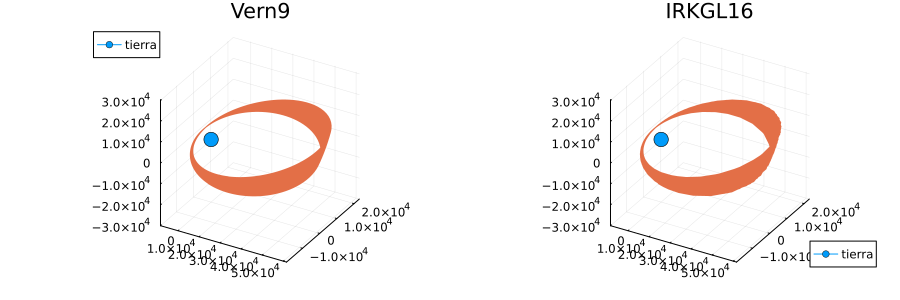

In [9]:
tt = sol1.t
xx = [u[1] for u in sol1.u]
yy = [u[2] for u in sol1.u]
zz = [u[3] for u in sol1.u]

m0 = max(1,div(Int64(length(sol1.t)),10000))

pl1=plot([0.],[0.],[0.],marker=8,label="tierra",
      title= "Vern9")
      
plot!(pl1,xx[1:m0:end],
      yy[1:m0:end],
      zz[1:m0:end], aspect_ratio=1., zlimit=(-3.0e4,3.04e4),  label="")


tt = sol2.t
xx = [u[1] for u in sol2.u]
yy = [u[2] for u in sol2.u]
zz = [u[3] for u in sol2.u]

m0 = max(1,div(Int64(length(sol2.t)),10000))

pl2=plot([0.],[0.],[0.],marker=8,label="tierra",
      title= "IRKGL16")
      
plot!(pl2,xx[1:m0:end],
      yy[1:m0:end],
      zz[1:m0:end], aspect_ratio=1., zlimit=(-3.0e4,3.04e4),  label="")


plot(pl1, pl2, layout=(1,2), size=(900,300))


## Error en energia

El error en energia en $t=t_k$ es $$ \left| \frac{E(u_k,p)-E(u_0,p)}{E(u_0,p)} \right|$$
donde $E(u_k,p)$ es la función que nos devuelve la energía de nuestro sistema.

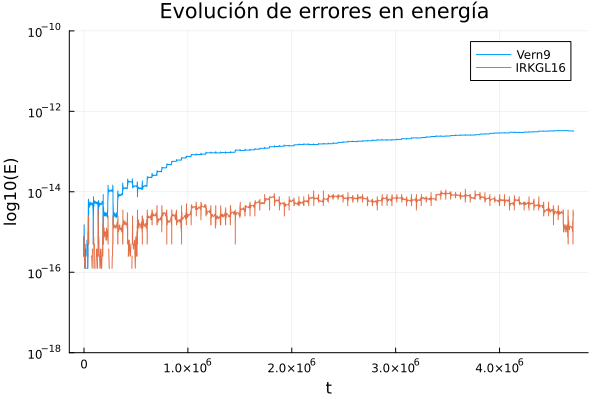

In [16]:
err1 = [ abs( ( Efun(u, p) - Efun(u0, p) ) / Efun(u0, p) ) for u in sol1.u ] 
err2 = [ abs( ( Efun(u, p) - Efun(u0, p) ) / Efun(u0, p) ) for u in sol2.u ] 

plot( xlabel="t",ylabel="log10(E)", 
     yscales=:log10, ylims=(1e-18,1e-10),
     title="Evolución de errores en energía ")


m0 = max(1,div(Int64(length(sol1.t)),10000))

plot!(sol1.t[1:m0:end], err1[1:m0:end], label="Vern9")
plot!(sol2.t, err2, label="IRKGL16")